<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-2-mg-ext/10-multigrid-anisotropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

In [2]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

sten = np.zeros((3,3))
sten[[0,1,1,2],[1,0,2,1]] = -1
sten[1,1] = 4

A = stencil_grid(sten, (4,4))

### Set up the operators

There are a couple of notes here:

- `relax` can be switch to `relaxGS`
- The poisson operator now as a rotation:
$$
-\varepsilon u_{xx} - u_{yy}
$$
leading to
$$
\left[
\begin{array}{rrr}
 & -1 & \\
 -\varepsilon & 2 + 2\varepsilon & -\varepsilon\\
 & -1 &
\end{array}
\right]
$$

In [3]:
def relaxJ(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 4 / 5
    
    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)

    return unew

def relaxGS(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    D = sparse.spdiags(A.diagonal(), [0], A.shape[0], A.shape[1], format='csr')
    E = -sparse.tril(A, -1)
    
    for i in range(nu):
        unew += sla.spsolve(D-E, f - A * unew)

    return unew

def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def poissonop(n, epsilon=1):
    """
    Create a 2D operator from a stencil.
    """
    #sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    sten = np.array([[ 0      ,           -1.,  0],
                     [-epsilon,  2+2*epsilon, -epsilon],
                     [0       ,           -1,  0]])
    A = stencil_grid(sten, (n, n))
    return A

### Start relaxing

As a start, let's view relaxation for this problem.

Play around with `epsilon`.  Look at `epsilon = 100, 1, 0.001`.

What happens to "smoothing"?

In [10]:
relax = relaxJ

k = 7
n = 2**k - 1
nc = 2**(k-1) - 1
A = poissonop(n, epsilon=0.001)
X, Y = np.meshgrid(np.linspace(0,1,n),
                   np.linspace(0,1,n))

u = np.random.rand(n,n).ravel()
f = np.zeros((n,n)).ravel()
unew = relax(A, u, f, 20)

(0.0, 1.0, 0.0, 1.0)

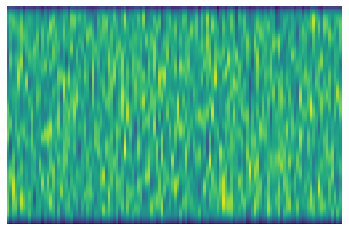

In [11]:
plt.pcolormesh(X, Y, unew.reshape((n,n)))
plt.axis('off')

## "Fourier" testing

We can get a sense of the smoothing properties by testing
relaxatio non a number of Fourier modes.

Here we will test the $(k_1, k_2)$ modes:
$$
\sin\left(\frac{k_1 i\pi}{n+1}\right)\sin\left(\frac{k_2 j\pi}{n+1}\right)
$$

In [16]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
A = poissonop(n, epsilon=0.001)
f = np.zeros((n,n)).ravel()
z = np.zeros((n,n))
for k1 in range(1,n+1):
    for k2 in range(1,n+1):
        v = np.outer(np.sin(np.arange(1,n+1) * k1 * np.pi / (n+1)),
                     np.sin(np.arange(1,n+1) * k2 * np.pi / (n+1)))
        v = v.ravel()
        nv0 = np.linalg.norm(v)
        m = 10
        v = relax(A, v, f, m)
        nv1 = np.linalg.norm(v)
        z[k1-1,k2-1] = (nv1 / nv0)**(1/m)

Text(0, 0.5, '$k_2$')

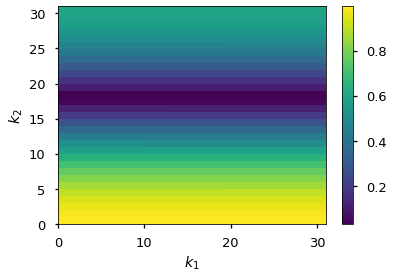

In [18]:
plt.pcolor(z)
plt.colorbar()
plt.xlabel('$k_1$')
plt.ylabel('$k_2$')

### A two grid method

We can try this: relax, restrict, solve, interpolate, correct

In [19]:
def twogrid(A, P, A1, u0, f0, nu):
    u0 = relax(A, u0, f0, nu)
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    u0 = relax(A, u0, f0, nu)
    return u0

Now run the solver over a range of values for $\varepsilon$:
$$
\varepsilon = 10^{-3}\dots 10^{3}
$$

In [20]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
elist = np.logspace(-3,3,50)

m = 20
allres = np.zeros((len(elist),m))

for i, epsilon in enumerate(elist):
    u = np.random.rand(n*n)
    f = np.zeros((n,n)).ravel()
    A = (n+1)**2 * poissonop(n, epsilon=epsilon)
    P1d = interpolation1d(nc, n)
    P = sparse.kron(P1d, P1d).tocsr()
    A1 = P.T * A * P
    for j in range(m):
        u = twogrid(A, P, A1, u, f, 1)
        res = np.linalg.norm(f - A * u)
        allres[i,j] = res

Text(0, 0.5, 'norm of the residual')

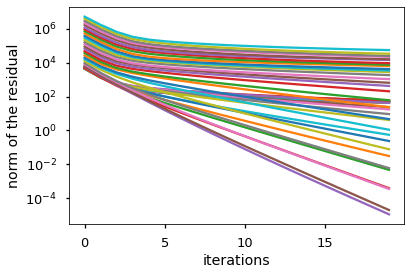

In [21]:
for i in range(len(elist)):
    plt.semilogy(allres[i,:])
plt.xlabel('iterations')
plt.ylabel('norm of the residual')

Instead, let's plot the convergence factors.

In this case, we'll use the geometric average of the last five iterates.

Text(0, 0.5, 'convergence factor')

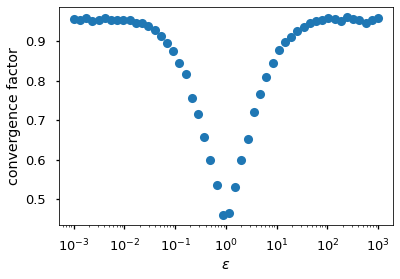

In [22]:
factors = []
for i in range(len(elist)):    
    factor = (allres[i,-1] / allres[i,-5])**(1/5)
    factors.append(factor)

plt.semilogx(elist, factors, 'o')
plt.xlabel('$\epsilon$')
plt.ylabel('convergence factor')